# TASK 1: SCHELLING MODEL

In [2]:
library(igraph)
library(ggplot2)
library(RColorBrewer)
library(rgl)
library(dplyr)
library(deSolve)
library(tidyverse)
library(FamilyRank)

In [3]:
## FUNCTION TO CALCULATE THE DISTANCE OF THE EDGE OF TWO GIVEN NODES
calculate_distances = function(attributes, uv, K){
    u = uv[1]
    v = uv[2]
    resta=attributes[u]-attributes[v]

    dist_toroidal=c(abs(resta+1),abs(resta-1),abs(resta))
    
    distance = min(dist_toroidal)*2
    #distance=resta
    discrete_distance = ceiling(distance*K)/K
    if (discrete_distance==0){
        discrete_distance = 1/K
    }
    return(discrete_distance)
}

In [4]:
## FUNCTION TO CALCULATE THE DISTANCE OF ALL THE EDGES
all_distances = function(attributes, uv, K){
    u = uv$row
    v = uv$col
    resta=attributes[u]-attributes[v]
    discrete_distance=c()
    for (i in 1:length(resta)){
        distance = min(abs(resta[i]+1),abs(resta[i]-1),abs(resta[i]))*2
        distance = round(ceiling(distance*K)/K,10)
        discrete_distance = append(discrete_distance, distance)
        
    }
    discrete_distance[discrete_distance==0]=1/K
    return(discrete_distance)
}

In [5]:
#FUNCTION TO CREATE THE INTIAL NETWORK
create_G0 = function(n, m, attr, K, type){
    max_edges = (n^2-n)/2 # the max number of edges if the network is fully connected, undirected and in absence of self-loops
    if (type=='random'){
        edges = sample(rep(c(0,1),c(max_edges-m,m)))  # randomly shuffled vector of length max_edges with as many 1's as edges
        G0 = matrix(0,n,n)
        G0[upper.tri(G0)] = edges
        G0[lower.tri(G0)] = t(G0)[lower.tri(G0)]
        diag(G0) = 0
    }
    else {
        if (type=='all_long'){
            decr=TRUE
        }
        if (type=='all_short'){
            decr=FALSE
            
        }
        edges = rep(1,max_edges)
        G0 = matrix(0,n,n)
        G0[upper.tri(G0)] = edges
        G0[lower.tri(G0)] = t(G0)[lower.tri(G0)]
        diag(G0) = 0
        edges = which(G0==1, arr.ind = TRUE) #take only the existed edges
        edges = data.frame(edges)
        edges = edges[edges$row<edges$col,]
        edges$distance = all_distances(attr,edges,K)
        edges = edges[sample(1:nrow(edges)), ]
        edges = edges[order(edges$distance,decreasing=decr),]
        edges = edges[1:m,]
        g0 = graph_from_data_frame(edges,directed=FALSE,vertices=data.frame(1:n))
        G0 = matrix(as_adjacency_matrix(g0),n,n)
        
    }
    return(G0)
}

In [6]:
# FUCNTION TO ASSIGN ATTRIBUTES TO EACH NODES
create_attributes = function(n, type){
    if (type=='uniform'){
        attributes = runif(n, 0, 1)
    }
    else if (type =='binormal'){
        attributes = c(runif(ceiling(n/2),0,1/4),runif(ceiling(n/2),1/2,3/4))
    }
    else if (type == 'minority'){
        attributes = c(runif(ceiling(3*n/4),0,1/4),runif(ceiling(n/4),1/2,3/4))
    }
    return(attributes)
}

In [7]:
# FUNCTION THAT TAKES RANDOMLY A EDGE:
#   - DECIDES IF IT HAS TO BE DESTROYED:
#        -YES->> CREATE ANOTHER EDGE RANDOMLY
#        -NO->> NOTHING HAPPENS
decide_break_create = function(n, m, p, K, G, attributes,type_p='unique'){
    
    max_edges = (n^2-n)/2
    breaks=0
    
    #We extract a random edge 
    pairs_nodes_break = which(G==1, arr.ind = TRUE) # Extract pair of nodes with an existing edge
    chosen_pair_break = pairs_nodes_break[sample(1:(2*m), 1),] # We choose randomly a pair of nodes. We choose among all the 1's in the matrix 
                                                         # (each pair is repeated twice. It does not affect the result).

    #Decision of breaking an edge and if so, creating another one
    breaking_threshold = runif(1, 0, 1) #random 
    if (type_p=='different'){
        p=max(p[chosen_pair_break[1]],p[chosen_pair_break[2]])
        }
    else if (type_p=='unique'){
        p=p
    }
    prob_breaking = p*calculate_distances(attributes,chosen_pair_break, K)
    if (prob_breaking>=breaking_threshold){
        breaks=1
        G_step = G

        G_step[chosen_pair_break[1], chosen_pair_break[2]]=0
        G_step[chosen_pair_break[2], chosen_pair_break[1]]=0

        pairs_nodes_create_diag = which(G_step==0, arr.ind = TRUE)  # Extract pair of nodes with an existing edge (!!also diagonal)
        pairs_nodes_create_idx = which(pairs_nodes_create_diag[,1]!=pairs_nodes_create_diag[,2])
        pairs_nodes_create = pairs_nodes_create_diag[pairs_nodes_create_idx,]  #We took out the digonal 0 options
        chosen_pair_create = pairs_nodes_create[sample(1:(2*(max_edges-m)), 1),] # We choose randomly a pair of nodes. We choose among all the 1's in the matrix 
                                                                           # (each pair is repeated twice. It does not affect the result).
        G_step[chosen_pair_create[1], chosen_pair_create[2]]=1
        G_step[chosen_pair_create[2], chosen_pair_create[1]]=1
        
        G_ = G_step

    }
    else{
        G_=G
    }
    return(list(G_,breaks))}

In [8]:
# FUNCTION THAT EVOLVES THE NETWORK FOR A GIVEN STEPS (FOR LOOP OF decide_break_create)
evolve_network = function(n, m, K, p, max_step, type_G0='random', type_attr='uniform', type_p='unique',num_saves=100 ){
    G_list = NULL
    attributes = create_attributes(n,type_attr)
    G0 = create_G0(n, m, attributes, K, type_G0)
    

    if (type_G0=='all_long'){
        attributes
    }
    save_each=round(max_step/num_saves,0)
    
    G = G0
    G_list=list(G)
    
    n_breaks=0 #counting the times an edge changes
    i=0 #index for deciding when to save G
    for (step in 1:max_step){

        next_step=decide_break_create(n,m,p,K,G, attributes, type_p)
        G=next_step[[1]]
        n_breaks=n_breaks+next_step[[2]]
        i=i+1
        if (i%%save_each==0){
            G_list=append(G_list,list(G))
        }

    }
    G_list=append(G_list,list(G))
    
    return(list(G_list,attributes,n_breaks))
}

In [9]:
# CALCULATE EI (total number of edges that have attribute distance i/K)
calculate_Ei = function(network,K){
    num_points=length(network[[1]]) #number of saved G_step
    attr=network[[2]]
    Ei_tot=data.frame(distance = round(c(seq(1/K,1,1/K)),10))

    for(j in 1:num_points){
        G_j=network[[1]][[j]] #take the G_j
        edges=which(G_j==1, arr.ind = TRUE) #take only the existed edges
        edges=data.frame(edges)
        edges$distance=all_distances(attr,edges,K) #calculate the distance of all the edges
        Ei = edges |> group_by(distance) |> summarise(counts = n()/2) #Total number of edges that have attribute distance
                                                                    # equal to i/K
        colnames(Ei)=c('distance',as.character(j))
        Ei_tot=merge(Ei_tot,Ei,by=c('distance','distance'),all=TRUE)
        
    }
    Ei_tot[is.na(Ei_tot)]=0
    return(Ei_tot)
}

In [10]:
# PLOT ALL Ei IN THE SAME FIGURE
plot_Ei=function(Ei,max_step,p){
    options(repr.plot.width = 15, repr.plot.height = 6)
    
    m=sum(Ei[,2])
    Ei_percentage=Ei[,2:length(Ei)]/m
    x_axis=seq(1,max_step,max_step/length(Ei_percentage)) #the number of the setep
    plot(x_axis,Ei_percentage[1,],ylab='Ei/m',xlab='steps (t)',ylim=c(0,max(Ei_percentage)*1.2),pch=16,main=paste('p=',p,sep=' '),col=2)#plot first line
    K=length(Ei[,1])
    labels=c(as.character(1/K)) #create first label
    for (j in 2:K){
        points(x_axis,Ei_percentage[j,],col=j+1,pch=16) #plot each line
        labels=append(labels,as.character(round(j/K,3))) #create the label for each new line
    }
    legend(x='topleft', legend = labels,col=(1:K),pch=16,bty='n')
}

In [11]:
# PLOT ALL Ei (simulation) AND ei (analytical) IN THE SAME FIGURE
plot_comparation = function(Ei,ei,max_step,p){
    options(repr.plot.width = 15, repr.plot.height = 10)
    
    m = sum(Ei[,2])
    Ei_percentage = Ei[,2:length(Ei)]/m
    x_axis = seq(1,max_step,max_step/length(Ei_percentage)) #the number of the setep
    plot(x_axis,Ei_percentage[1,],ylab='Ei/m',xlab='steps (t)',ylim=c(0,max(Ei_percentage)*1.2),col=2,lwd=2,main=paste('p=',p,sep=' '))#plot first points simulation
    lines(ei[,1]*m,ei[,2],col=2,lwd=2)#plot first line analytical
    K = length(Ei[,1])
    labels = c(as.character(1/K)) #create first label
    for (j in 2:K){
        points(x_axis,Ei_percentage[j,],col=j+1,lwd=2) #plot each points simulation
        lines(ei[,1]*m,ei[,j+1],col=j+1,lwd=2)#plot each lines analytical
        labels=append(labels,as.character(round(j/K,3))) #create the label for each new line
    }
    
    legend(x = 'topright', legend = c(labels,'Simulation','Analytical'),col = c(2:(K+1),1,1),pch = c(rep(15,K),1,NA),lty = c(rep(NA,K+1),1),s = 0.75,bty = 'n')
    
}

In [12]:
# FUNCTION FOR f(x), WILL BE USED TO SOLVE THE ODES FOR ei
# f(x)=1-sum(ei(x)*(K-1)/K)

f = function(K,y){
    e_ = c()
    for(i in 1:K-1){
        ei_ = y[i]*(K-i)/K #ei_=ei*(K-i)/K
        e_ = append(e_,ei_) 
    }
    f = 1-sum(e_)
    return(f)
}

In [13]:
# DEFINITION OF THE SYSTEM OF ODEs. yi=e'i, x=m*step
system_odes = function(x,y,params){
    K_ = params['K']
    p_ = params['p']
    dydx = c()
    for(i in 1:K_){
        f_part = f(K_,y)*p_/K_
        e_part = y[i]*i*p_/K_
        dydx_i = f_part-e_part
        dydx = append(dydx,dydx_i)
    }
    return(list(dydx))
}

In [14]:
# SOLVING THE SYSTEM OF ODEs.
ei_analytical = function(K,p,m,type_G0='random',type_attr='uniform'){
    params = c('K'=K,'p'=p)
    x = seq(from=0,to=max_step,by=max_step/300)/m #continous time
    if (type_G0=='random' & type_attr=='uniform'){
        y_0 = c(rep(1/K,K)) #uniform initial condition
    }
    if (type_G0=='all_long' & type_attr=='uniform'){
        y_0 = c(rep(0,K-1),1) #uniform initial condition
    }
    if (type_G0=='all_short' & type_attr=='uniform'){
        y_0 = c(1,rep(0,K-1)) #uniform initial condition
    }

    ei_analytic = ode(
      func=system_odes,
      y = y_0,
      times = x,
      parms = params
    ) 
    return(ei_analytic)
}

In [15]:
take_edges=function(network,step,K){
    G=network[[1]][[step]]
    attr=network[[2]]
    edges=which(G==1, arr.ind = TRUE) #take only the existed edges
    edges=data.frame(edges)
    edges$distance=all_distances(attr,edges,K)
    proper_edges=ts(edges[edges$row<edges$col,])
    return(proper_edges)
}

In [16]:
plot_graphs = function(K, network,max_step, num_saves,choosen_steps=c(1,num_saves)){
    
    attr=network[[2]]
    color_vertex=attr
    color_vertex[color_vertex<=0.5]='green'
    color_vertex[color_vertex!='green']='blue'

    shape_vertex=attr
    shape_vertex[shape_vertex<=0.5]='square'
    shape_vertex[shape_vertex!='square']='circle'
    
    #size_=round((abs(attr-0.5)*20),5)
    size_=round(p^1.5*15,100)

    
    plot_list = choosen_steps
    options(repr.plot.width = 15, repr.plot.height = 10)
    par(mfrow=c(2,ceiling(length(choosen_steps)/2)))
    
    for (save in plot_list){
        
        edges=take_edges(network, save,K)
        colnames(edges)=c('from','to','weight')
        edges=data.frame(edges)
        edges$weight=edges$weight^(-2)
        g=graph_from_data_frame(edges,directed=FALSE,vertices=data.frame(1:n))

        lay=layout_with_fr(g)

        plot(g,vertex.color=color_vertex, vertex.shape=shape_vertex, vertex.label=NA,edge.curved=0.2,vertex.size=size_,layout=lay,main=paste('STEP:',ceiling((save-1)*max_step/num_saves)))
        
    }
    return(g)
}

All functions defined, let's create and evolve some networks

# ANALITICAL AND SIMULATED RESULTS FOR Ei

### Random G0 p=0.5

In [17]:
n = 100
m = 300
K = 4
p = 0.5
max_step = 5*m*log(m)  #mlog(m) minimum time to reach convergence
num_saves = 50 # num of saved steps of G (there will be actually 2 more: initial and final)

#only works for  type_G0 = 'random', type_attr = 'uniform':
type_G0 = 'random'
type_attr = 'uniform'
type_p = 'unique'

network = evolve_network (n, m, K, p, max_step, type_G0, type_attr, type_p, num_saves) #create and evolve the network
attributes=network[[2]] #extract the attributes
Ei = calculate_Ei(network,K) #calculate simulated results
ei_a = ei_analytical(K,p,m,type_G0,type_attr) #calcualte analytical results

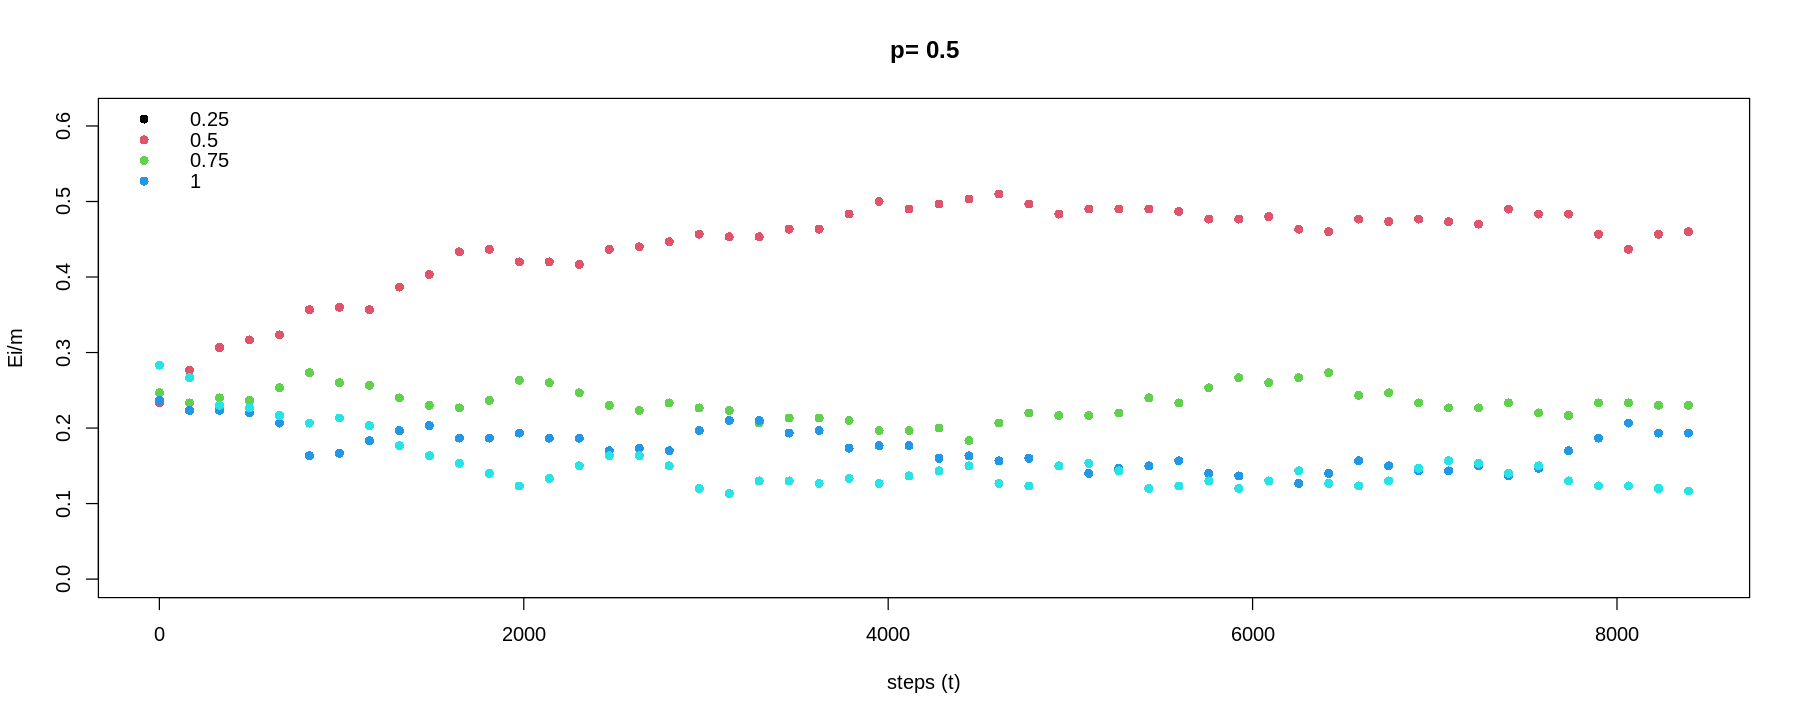

In [18]:
#ONLY SIMULATED RESULTS
plot_Ei(Ei,max_step,p)

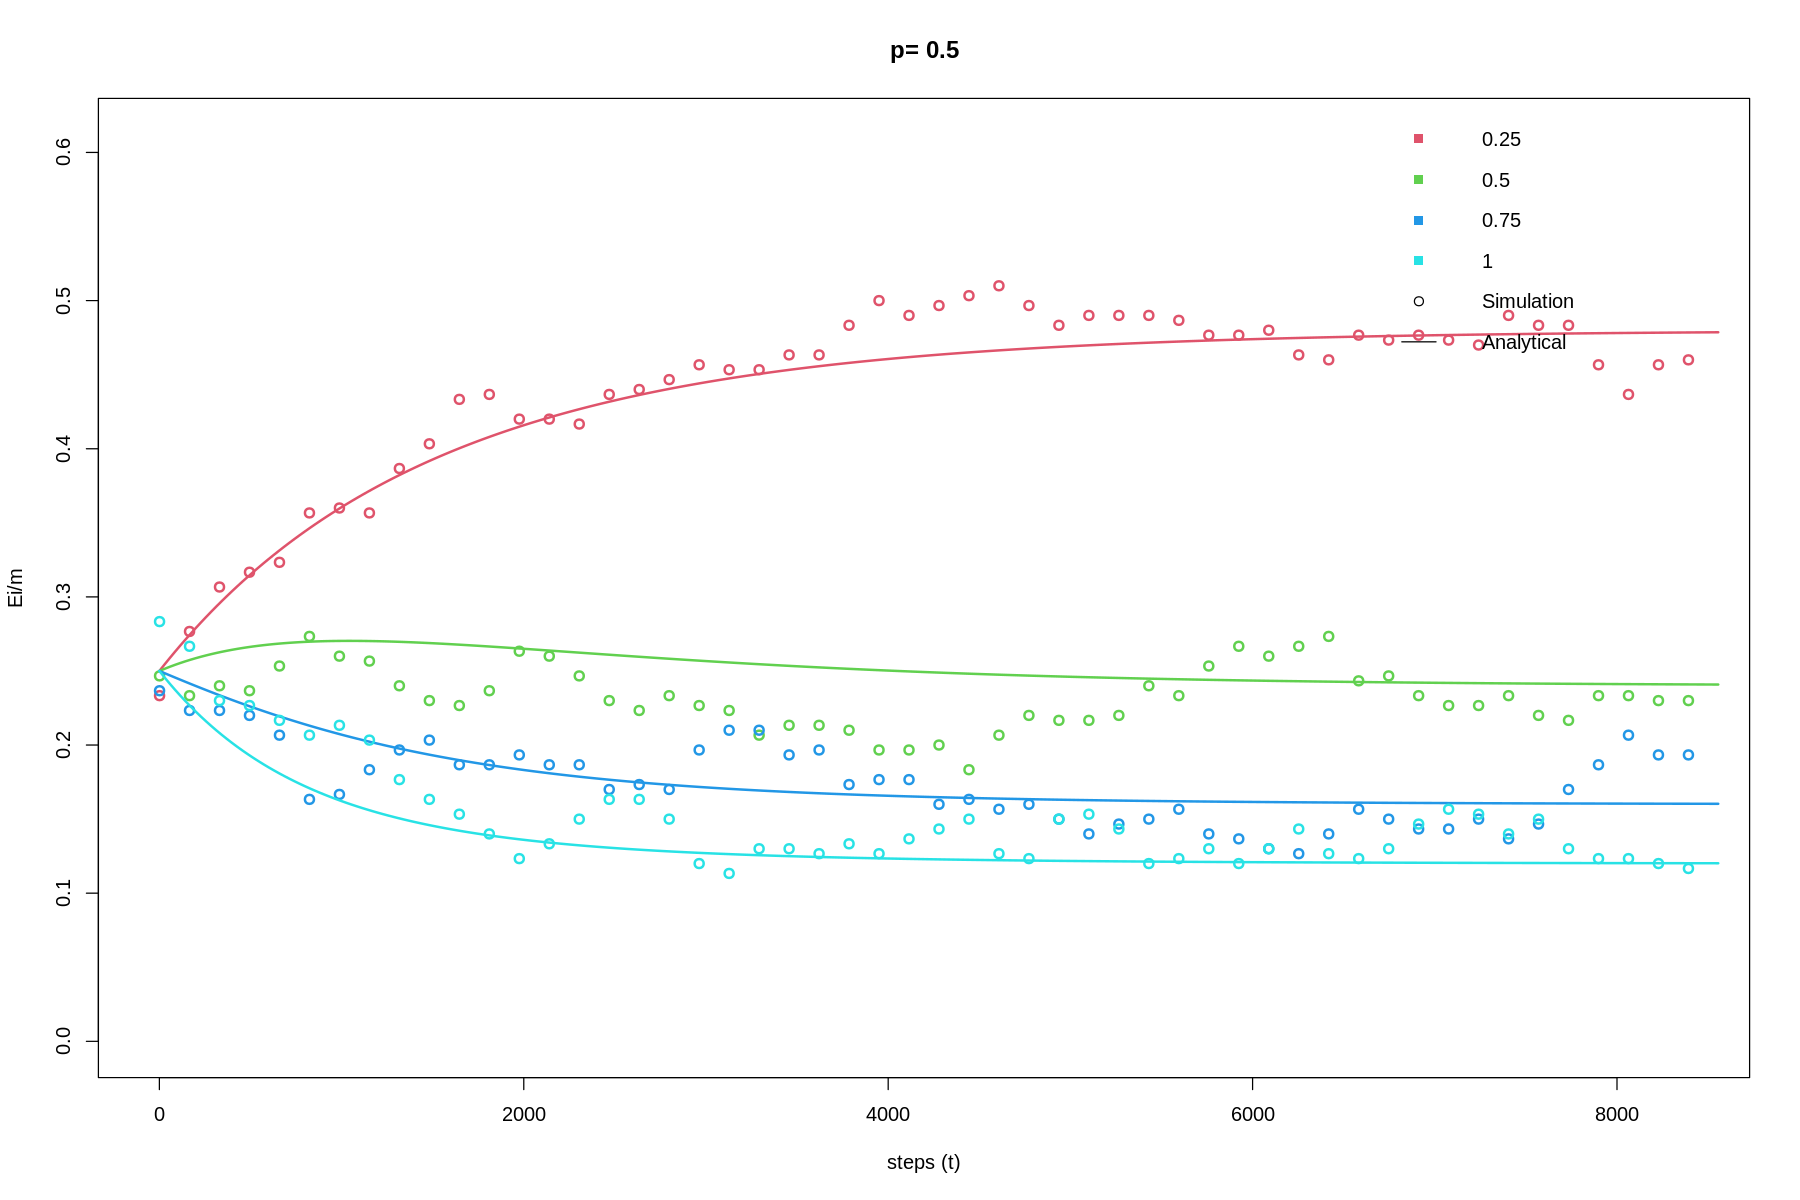

In [19]:
# COMPARE ANALYTICAL AND SIMULATED RESULTS
plot_comparation(Ei,ei_a,max_step,p)

### Random G0 p=0.1

In [20]:
n = 100
m = 300
K = 4
p = 0.1
max_step = 5*m*log(m)  #mlog(m) minimum time to reach convergence
num_saves = 50 # num of saved steps of G (there will be actually 2 more: initial and final)

#only works for  type_G0 = 'random', type_attr = 'uniform':
type_G0 = 'random'
type_attr = 'uniform'
type_p = 'unique'

network = evolve_network (n, m, K, p, max_step, type_G0, type_attr, type_p, num_saves) #create and evolve the network
attributes=network[[2]] #extract the attributes
Ei = calculate_Ei(network,K) #calculate simulated results
ei_a = ei_analytical(K,p,m,type_G0,type_attr) #calcualte analytical results

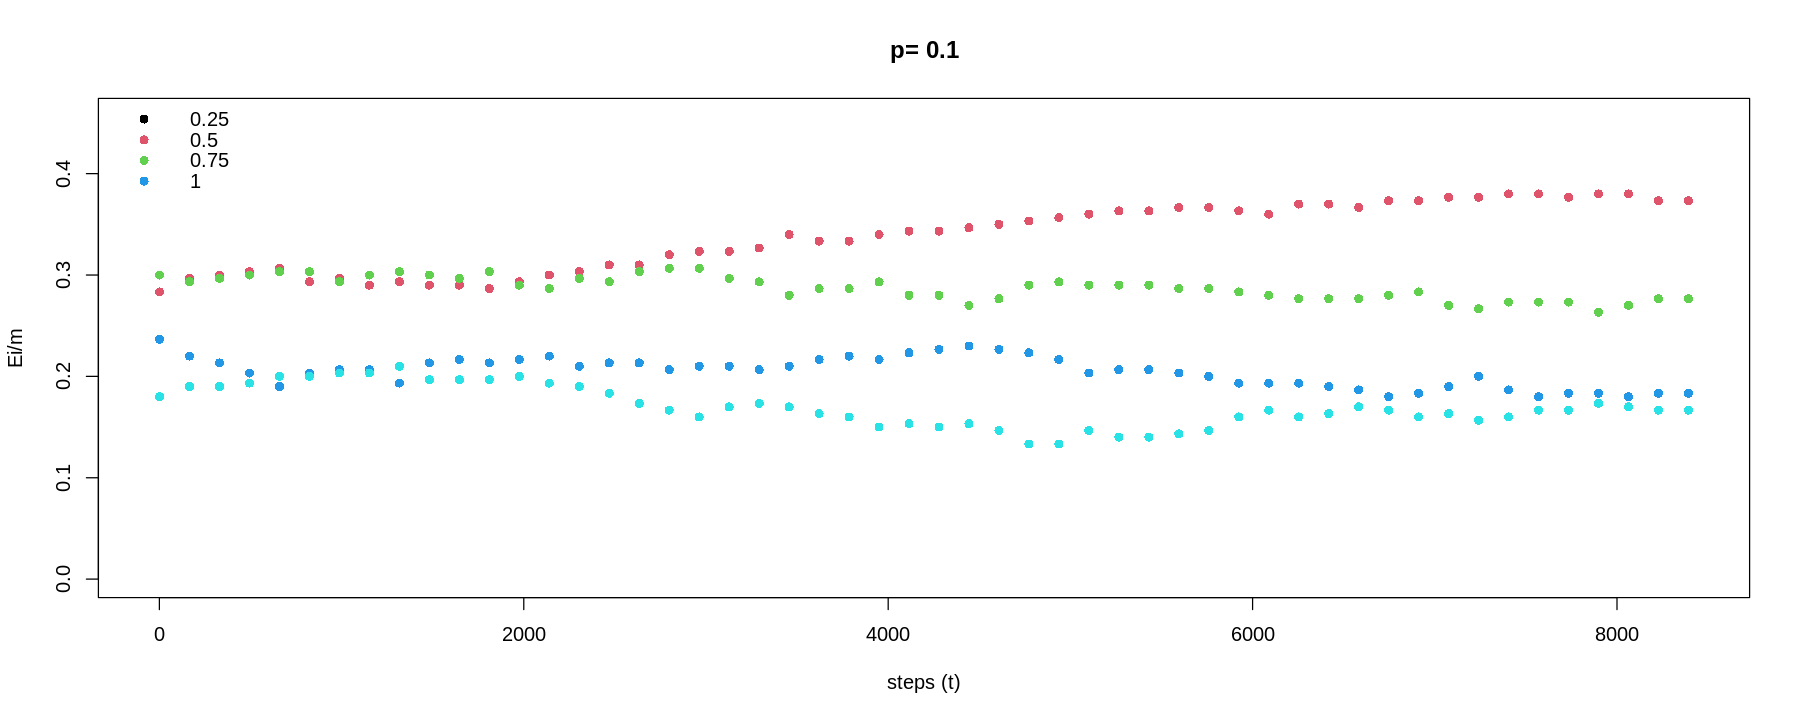

In [21]:
#ONLY SIMULATED RESULTS
plot_Ei(Ei,max_step,p)

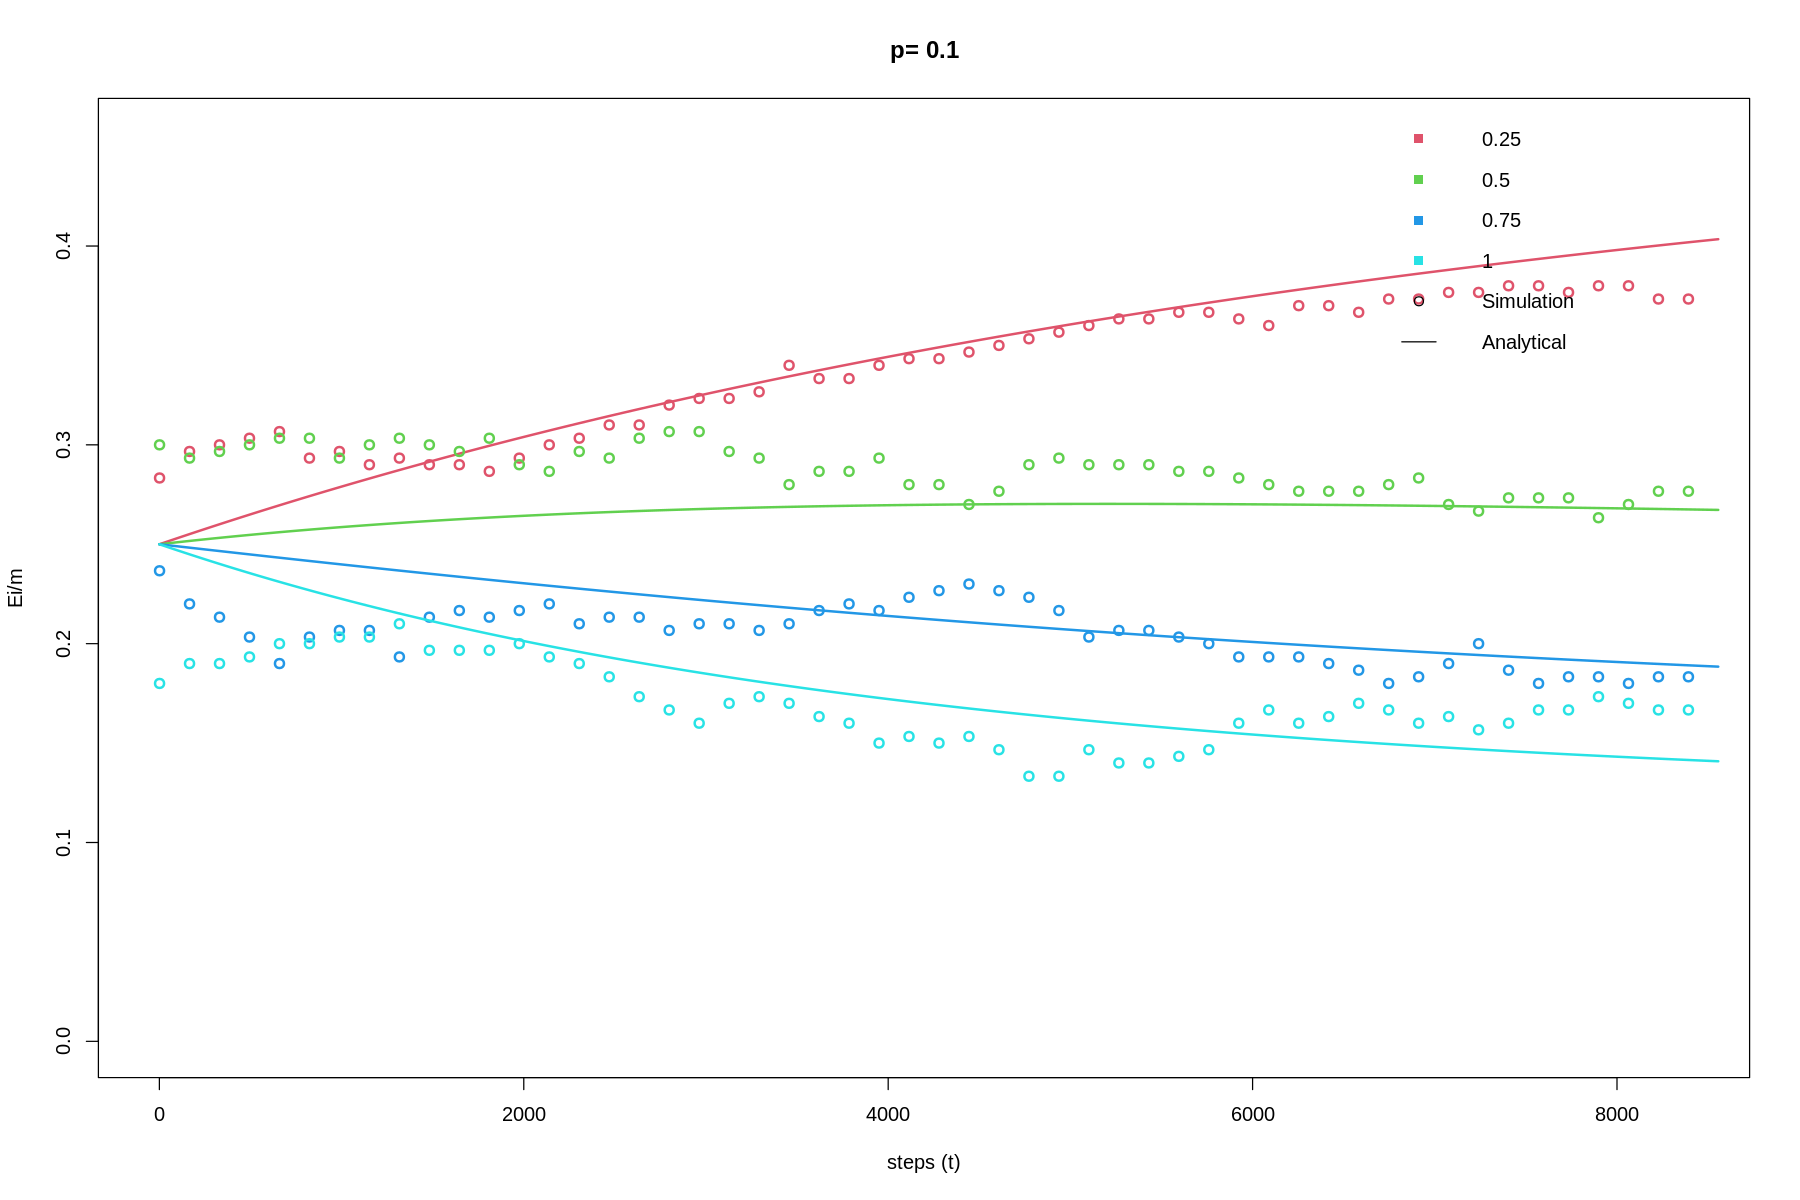

In [22]:
# COMPARE ANALYTICAL AND SIMULATED RESULTS
plot_comparation(Ei,ei_a,max_step,p)

### Only short edges G0

In [23]:
n = 100
m = 300
K = 4
p = 0.5
max_step = 5*m*log(m)  #mlog(m) minimum time to reach convergence
num_saves = 50 # num of saved steps of G (there will be actually 2 more: initial and final)

#only works for  type_G0 = 'random', type_attr = 'uniform':
type_G0 = 'all_short'
type_attr = 'uniform'
type_p = 'unique'

network = evolve_network (n, m, K, p, max_step, type_G0, type_attr, type_p, num_saves) #create and evolve the network
attributes=network[[2]] #extract the attributes
Ei = calculate_Ei(network,K) #calculate simulated results
ei_a = ei_analytical(K,p,m,type_G0,type_attr) #calcualte analytical results

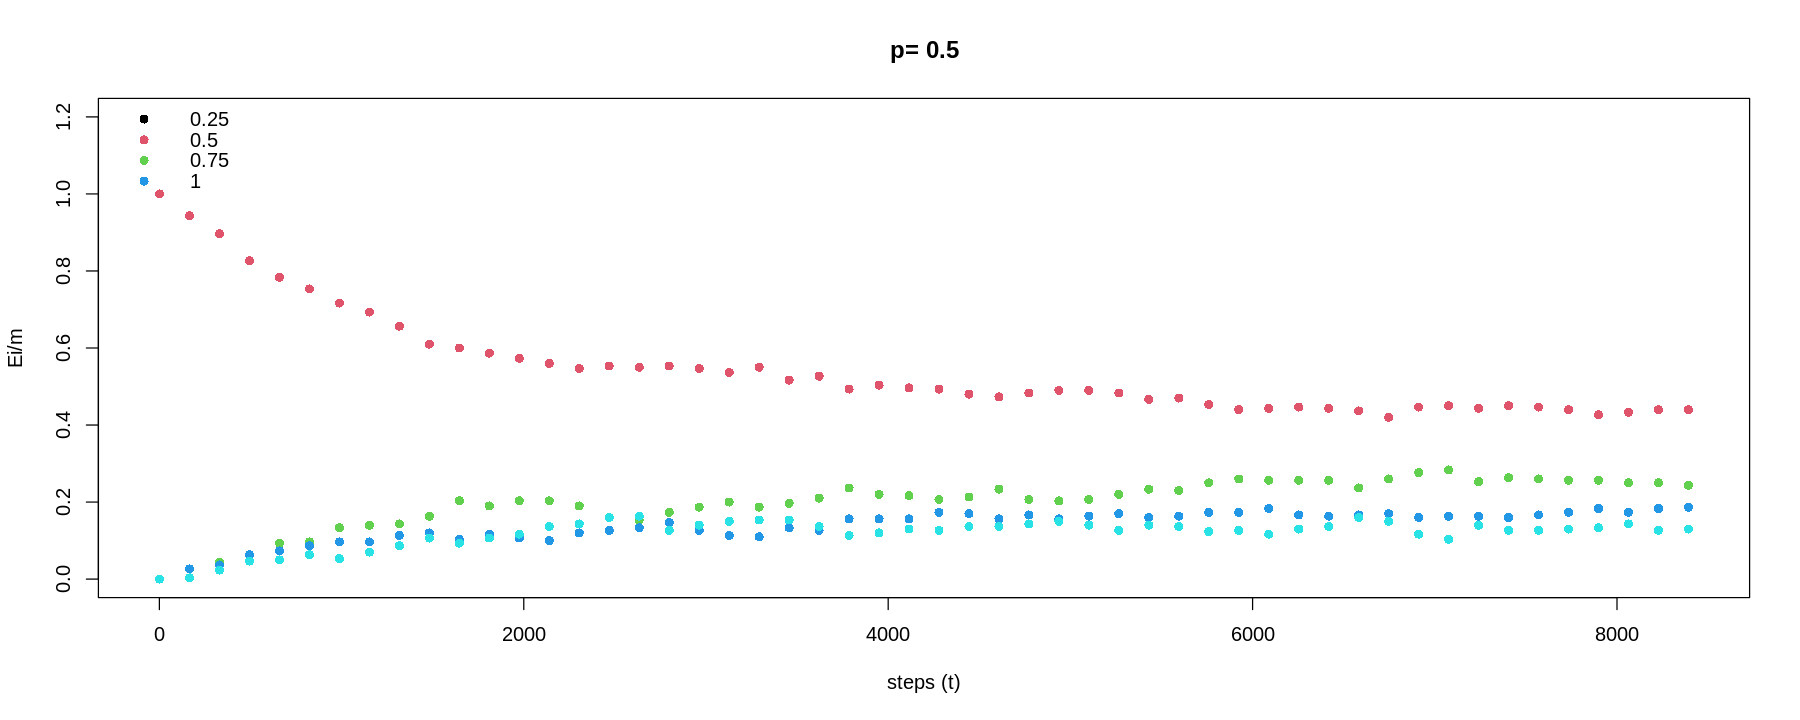

In [24]:
#ONLY SIMULATED RESULTS
plot_Ei(Ei,max_step,p)

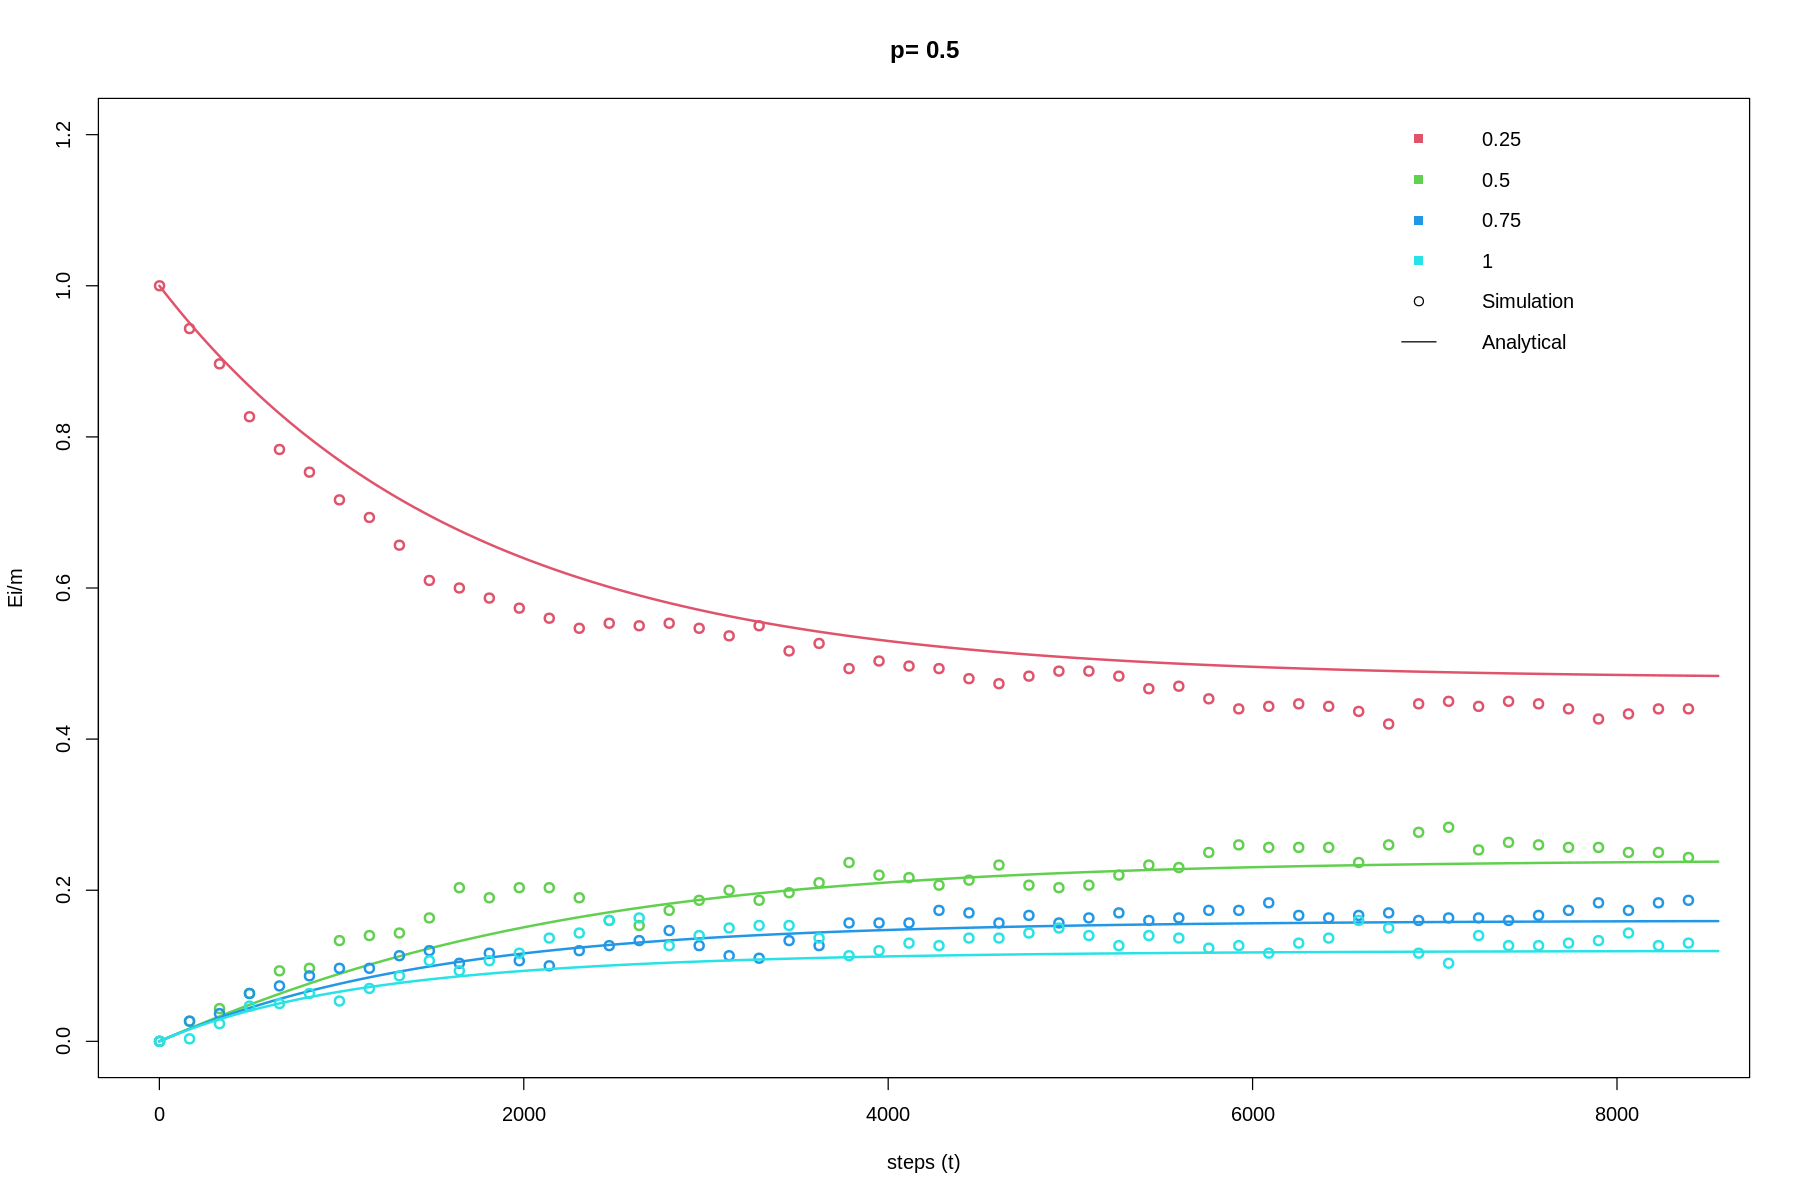

In [25]:
# COMPARE ANALYTICAL AND SIMULATED RESULTS
plot_comparation(Ei,ei_a,max_step,p)

### Only long edges G0

In [26]:
n = 300
m = 1000
K = 4
p = 0.5
max_step = 5*m*log(m)  #mlog(m) minimum time to reach convergence
num_saves = 50 # num of saved steps of G (there will be actually 2 more: initial and final)

#only works for  type_G0 = 'random', type_attr = 'uniform':
type_G0 = 'all_long'
type_attr = 'uniform'
type_p = 'unique'

network = evolve_network (n, m, K, p, max_step, type_G0, type_attr, type_p, num_saves) #create and evolve the network
attributes=network[[2]] #extract the attributes
Ei = calculate_Ei(network,K) #calculate simulated results
ei_a = ei_analytical(K,p,m,type_G0,type_attr) #calcualte analytical results

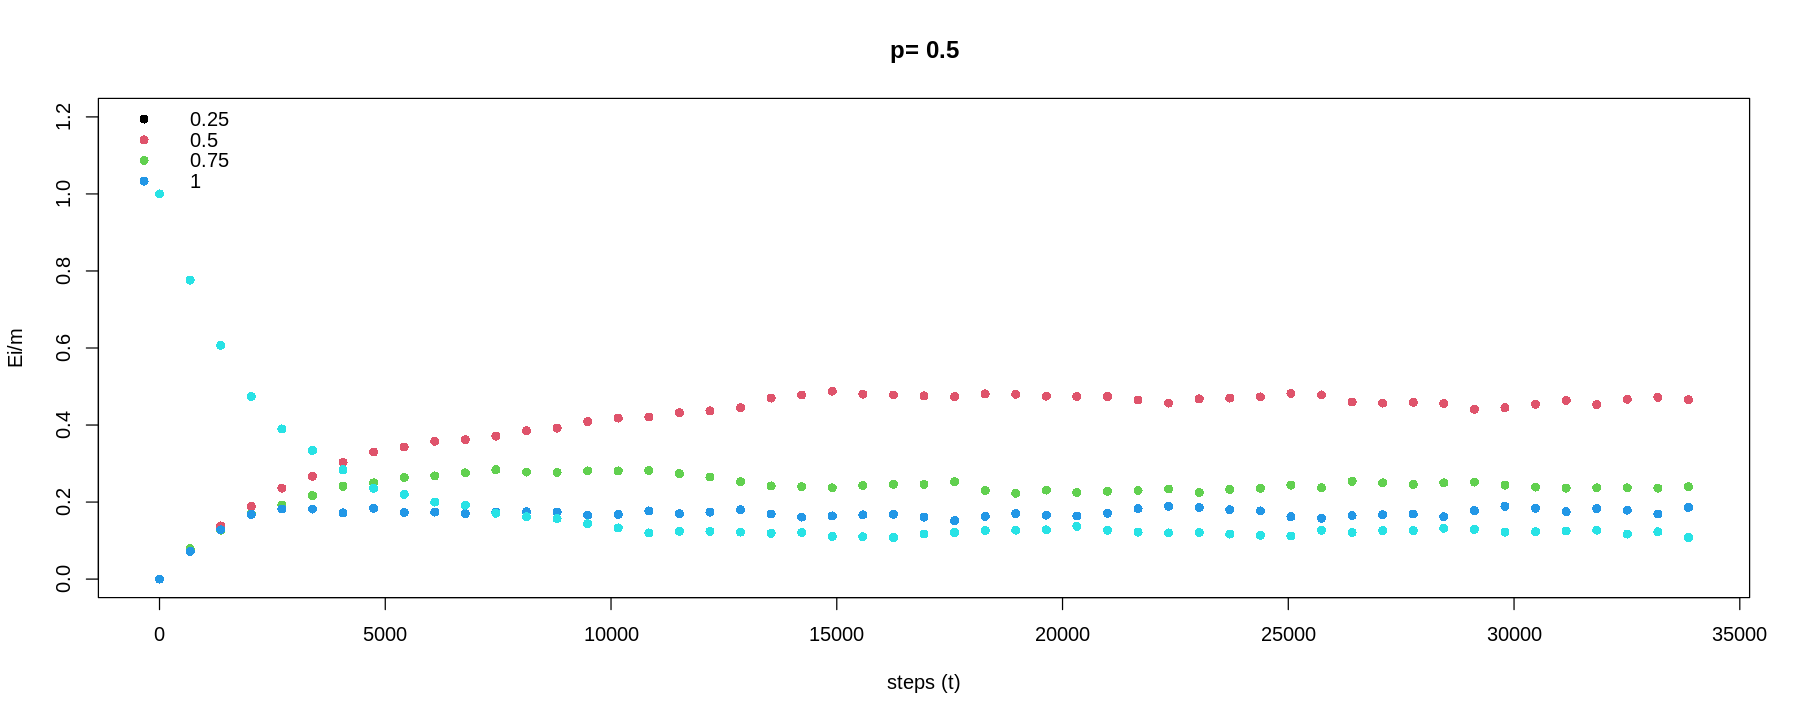

In [27]:
#ONLY SIMULATED RESULTS
plot_Ei(Ei,max_step,p)

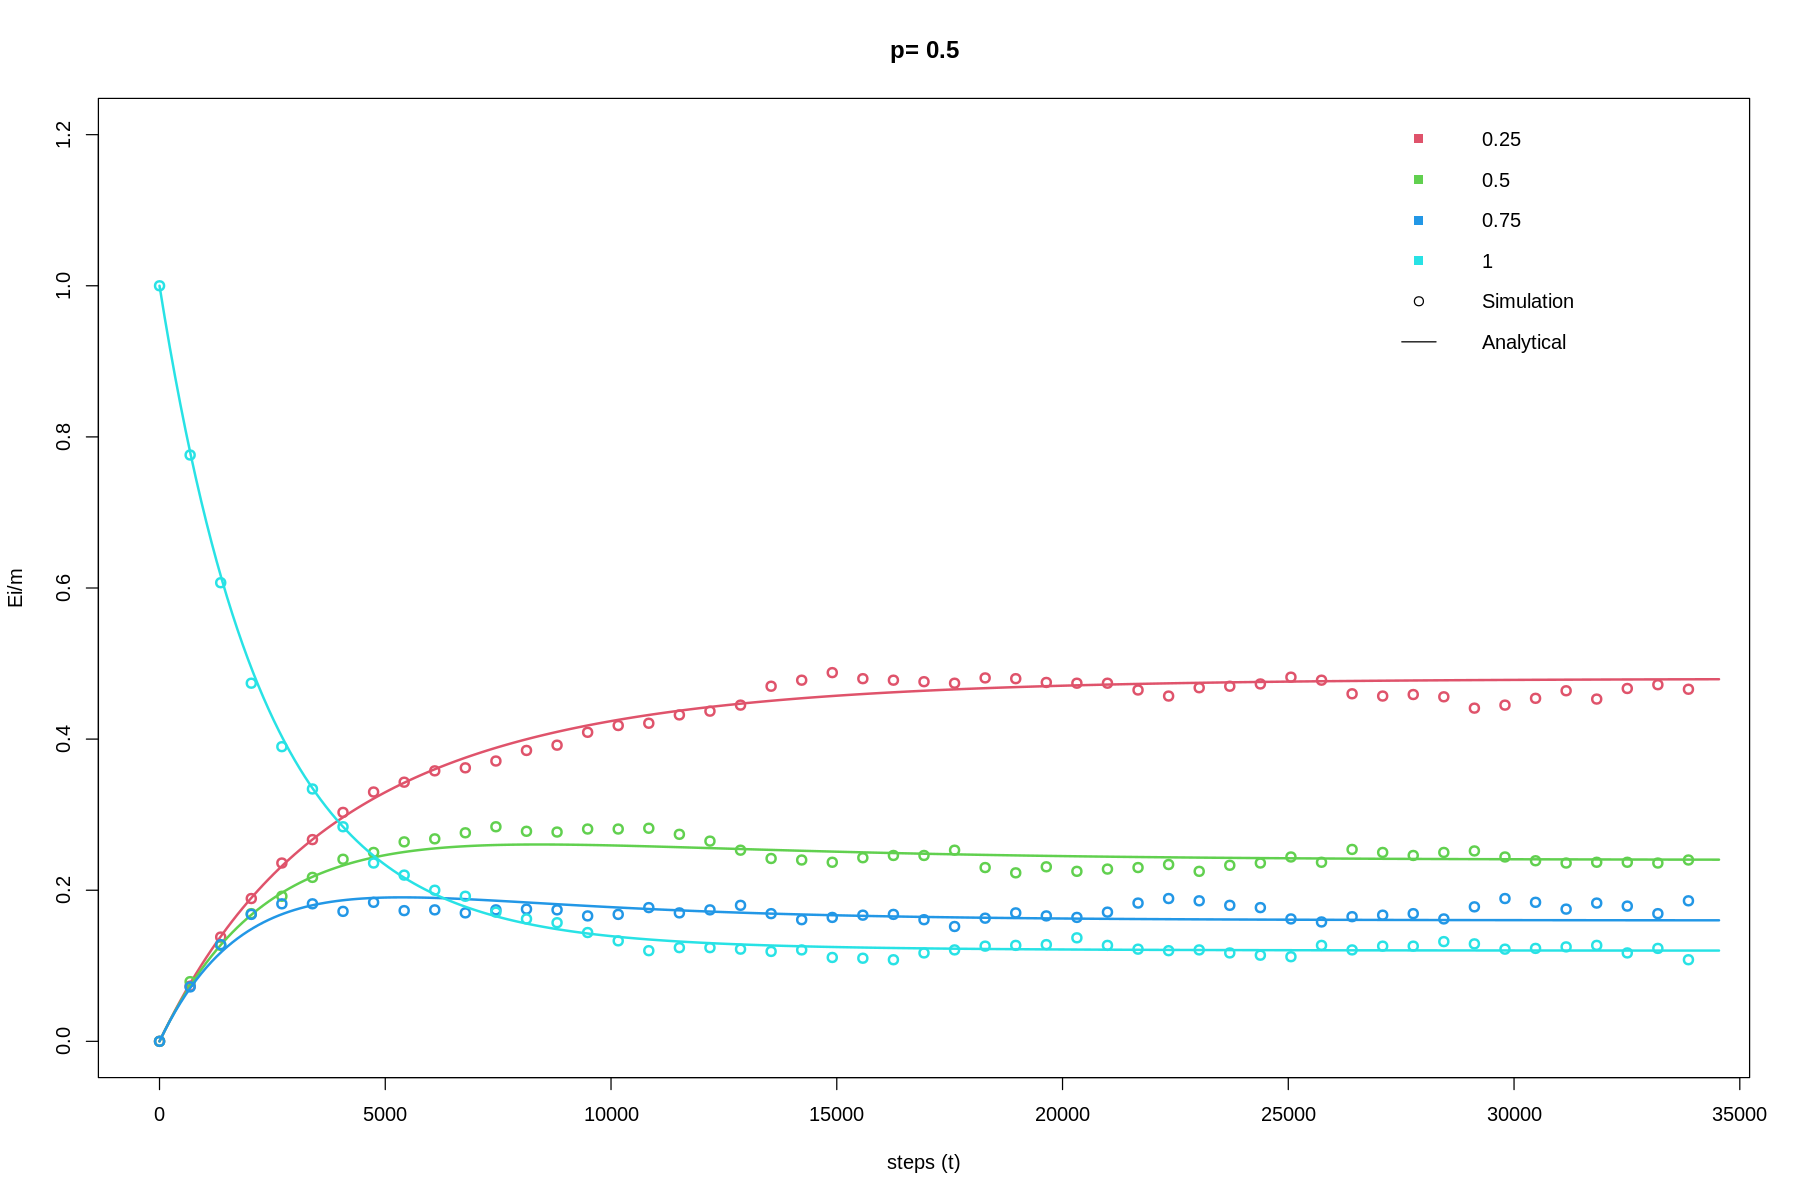

In [28]:
# COMPARE ANALYTICAL AND SIMULATED RESULTS
plot_comparation(Ei,ei_a,max_step,p)

# GRAPHS

### Same p

In [29]:
n = 100
m = 300
K = 100
p = 0.5
max_step = 5*m*log(m)  #mlog(m) minimum time to reach convergence
num_saves = 50 # num of saved steps of G (there will be actually 2 more: initial and final)

#now we use the binormal dsitribution for the attributes so we can se properly a segregation between both 'colors'
type_G0 = 'random'
type_attr = 'binormal'

network = evolve_network (n, m, K, p, max_step, type_G0, type_attr, num_saves)
attributes=network[[2]]
Ei = calculate_Ei(network,K) #calculate simulated results

In [30]:
#ONLY SIMULATED RESULTS
#plot_Ei(Ei,max_step,p)

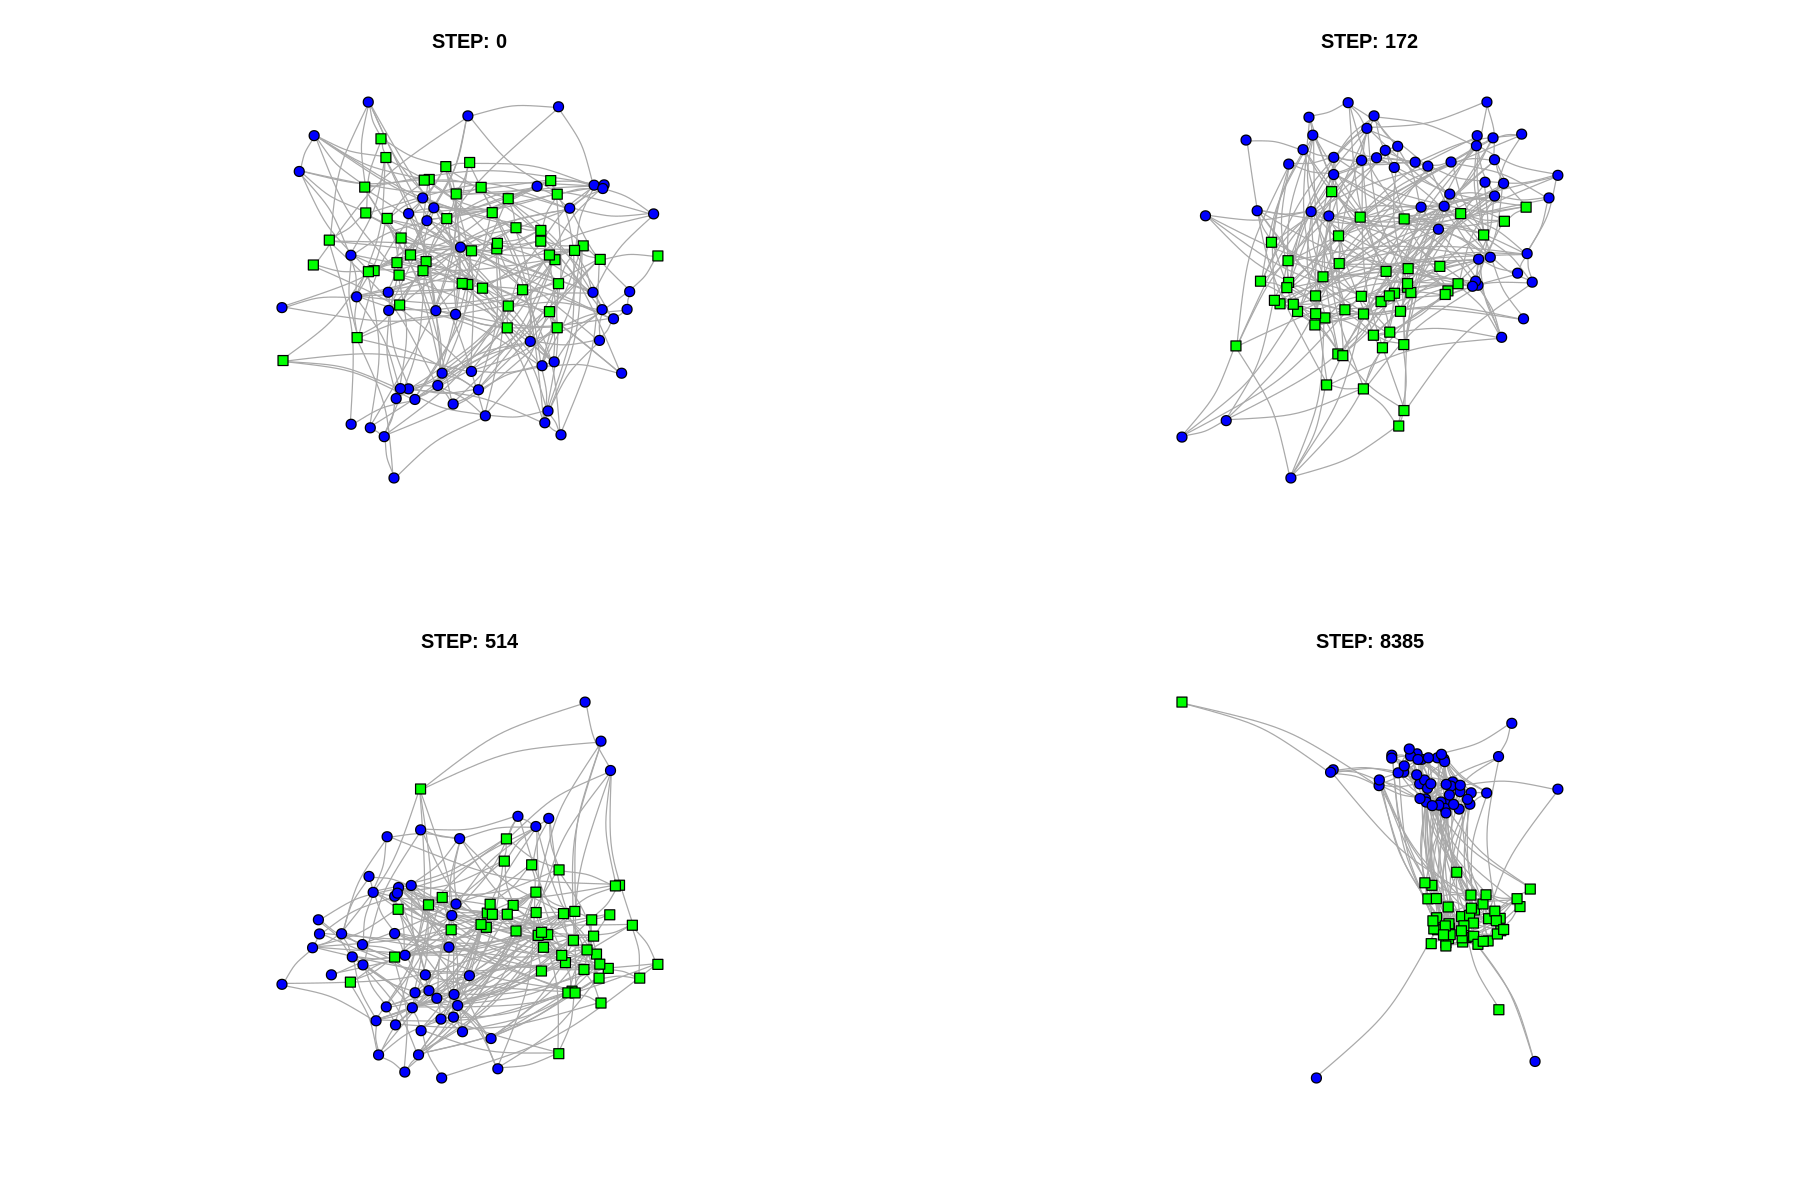

In [31]:
choosen_steps=c(1,2,4,num_saves) #which steps of G we want to plot
g=plot_graphs(K, network, max_step,num_saves,choosen_steps)


### Different p

In [32]:
n = 100
m = 300
K = 100
p = runif(n)
max_step = 5*m*log(m)  #mlog(m) minimum time to reach convergence
num_saves = 50 # num of saved steps of G (there will be actually 2 more: initial and final)

#only works for  type_G0 = 'random', type_attr = 'uniform':
type_G0 = 'random'
type_attr = 'binormal'
type_p = 'different'

network = evolve_network (n, m, K, p, max_step, type_G0, type_attr, type_p, num_saves) #create and evolve the network
attributes=network[[2]] #extract the attributes
Ei = calculate_Ei(network,K) #calculate simulated results


In [33]:
#ONLY SIMULATED RESULTS
#plot_Ei(Ei,max_step,'different')

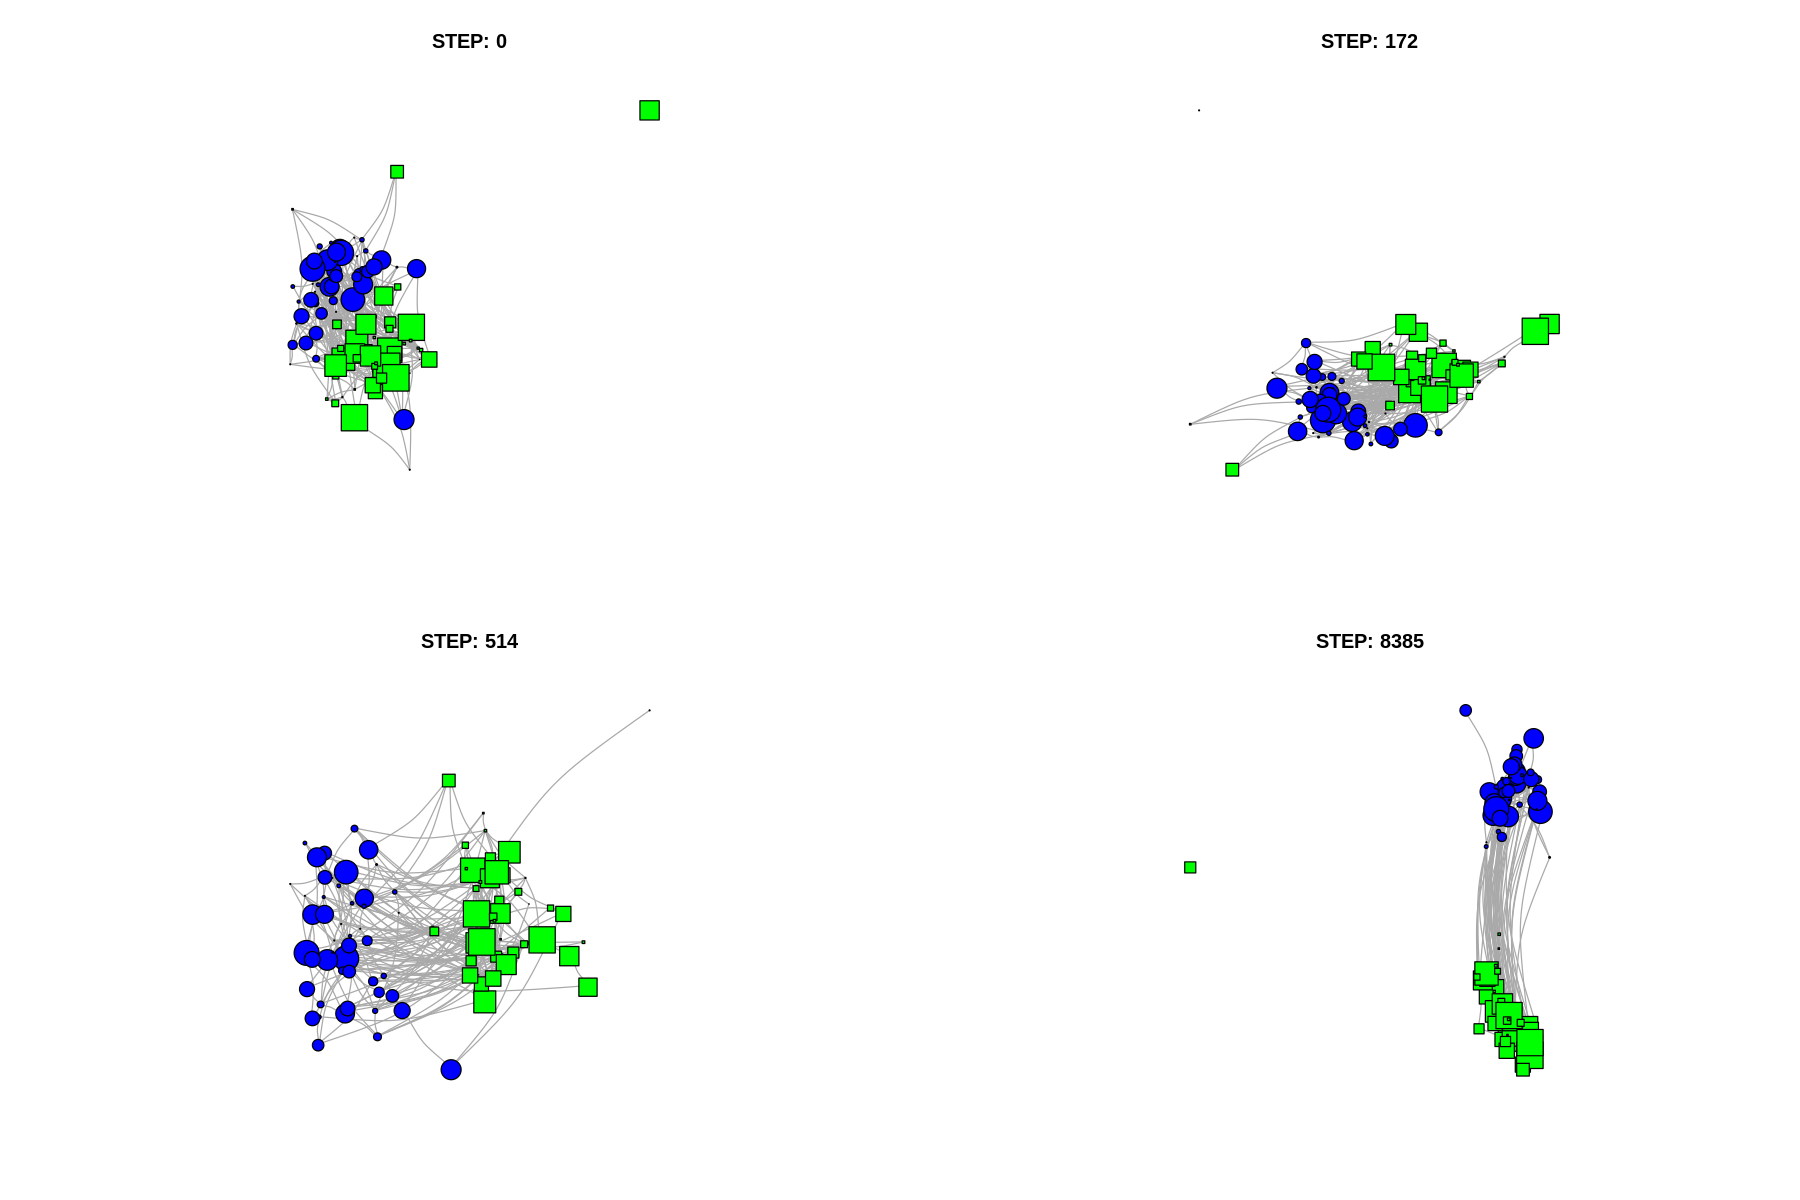

In [34]:
choosen_steps=c(1,2,4,num_saves) #which steps of G we want to plot
g=plot_graphs(K, network, max_step,num_saves,choosen_steps)

### Minority (same p)

In [35]:
n = 100
m = 300
K = 100
p = 0.5
max_step = 5*m*log(m)  #mlog(m) minimum time to reach convergence
num_saves = 50 # num of saved steps of G (there will be actually 2 more: initial and final)

#only works for  type_G0 = 'random', type_attr = 'uniform':
type_G0 = 'random'
type_attr = 'minority'
type_p = 'unique'

network = evolve_network (n, m, K, p, max_step, type_G0, type_attr, type_p, num_saves) #create and evolve the network
attributes=network[[2]] #extract the attributes
Ei = calculate_Ei(network,K) #calculate simulated results


In [36]:
#ONLY SIMULATED RESULTS
#plot_Ei(Ei,max_step,'0.5')

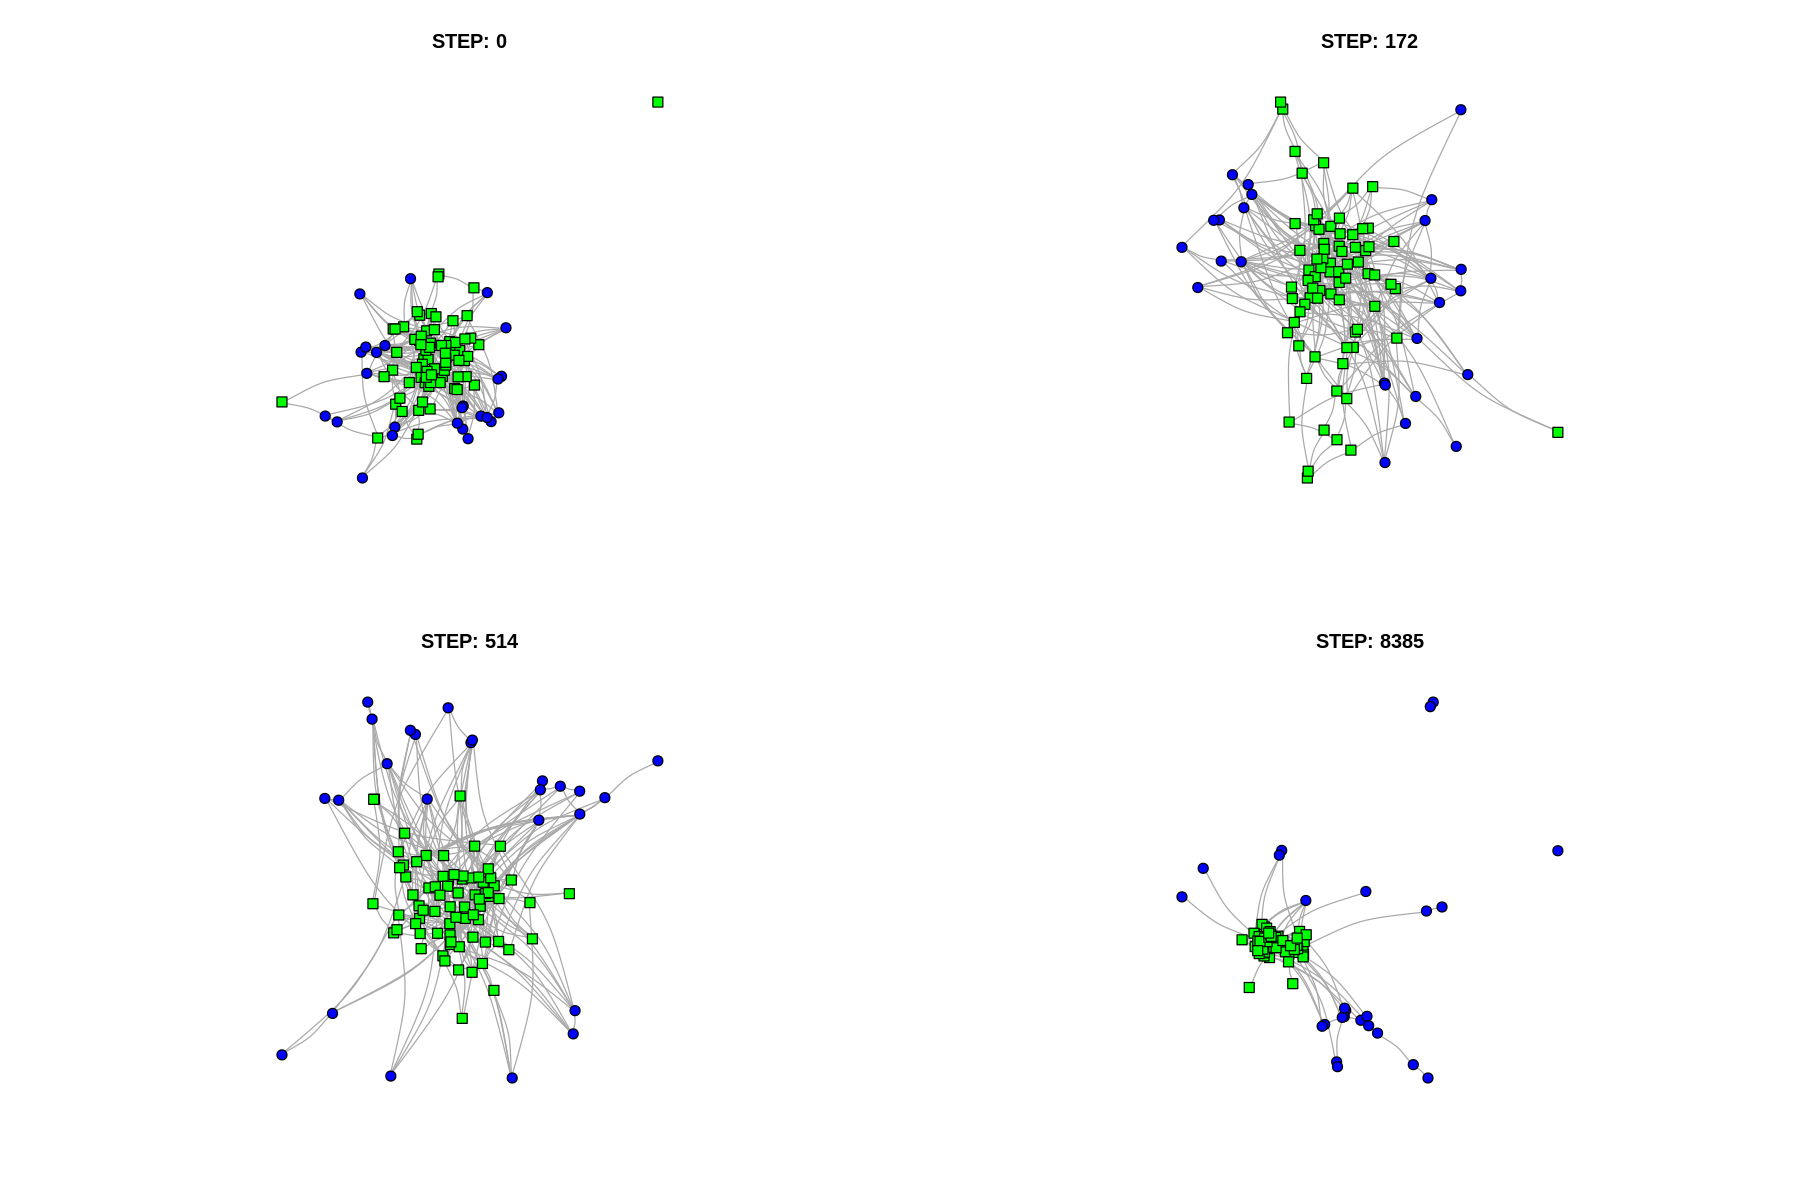

In [37]:
choosen_steps=c(1,2,4,num_saves) #which steps of G we want to plot
g=plot_graphs(K, network, max_step,num_saves,choosen_steps)